In [1]:
from datascience import *
path_data = '../assets/data/'
import numpy as np

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# A/B Testing
In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called *A/B testing*. The name refers to the labels of the two samples, A and B.

We will develop the method in the context of an example. The data come from a sample of newborns in a large hospital system. We will treat it as if it were a simple random sample though the sampling was done in multiple stages. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this set is drawn. 

## Smokers and Nonsmokers
The table `births` contains the following variables for 1,174 mother-baby pairs: the baby's birth weight in ounces, the number of gestational days, the mother's age in completed years, the mother's height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.

In [2]:
births = Table.read_table(path_data + 'baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


One of the aims of the study was to see whether maternal smoking was associated with birth weight. Let's see what we can say about the two variables.

We'll start by selecting just `Birth Weight` and `Maternal Smoker`. There are 715 non-smokers among the women in the sample, and 459 smokers.

In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


In [5]:
births.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


Let's look at the distribution of the birth weights of the babies of the non-smoking mothers compared to those of the smoking mothers. To generate two overlaid histograms, we will use `hist` with the optional `group` argument which is a column label or index. The rows of the table are first grouped by this column and then a histogram is drawn for each one.

귀무 가설이 ~~ 랬는데, 결과는 아래와 같았다. 

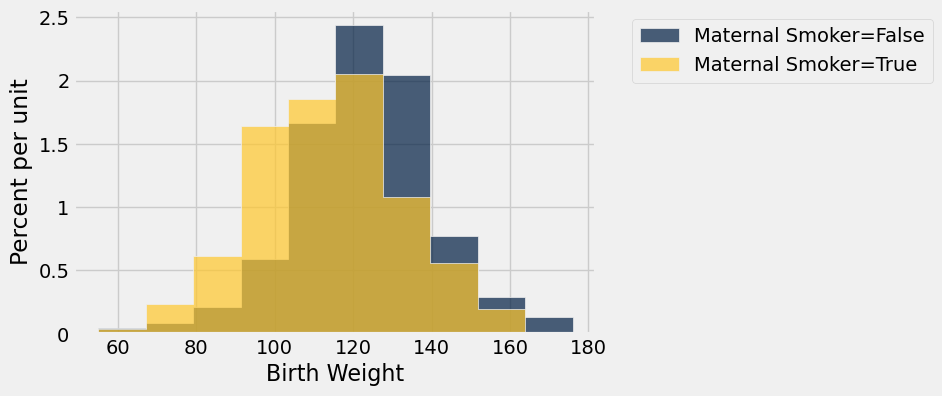

In [6]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')
plots.show()

검정 통계량?

The distribution of the weights of the babies born to mothers who smoked appears to be based slightly to the left of the distribution corresponding to non-smoking mothers. The weights of the babies of the mothers who smoked seem lower on average than the weights of the babies of the non-smokers. 

This raises the question of whether the difference reflects just chance variation or a difference in the distributions in the larger population. Could it be that there is no difference between the two distributions in the population, but we are seeing a difference in the samples just because of the mothers who happened to be selected?

## The Hypotheses
We can try to answer this question by a test of hypotheses. The chance model that we will test says that there is no underlying difference in the populations; the distributions in the samples are different just due to chance. 

Formally, this is the null hypothesis. We are going to have to figure out how to simulate a useful statistic under this hypothesis. But as a start, let's just state the two natural hypotheses.

**Null hypothesis:** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis:** In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.

## Test Statistic
The alternative hypothesis compares the average birth weights of the two groups and says that the average for the mothers who smoke is smaller. Therefore it is reasonable for us to use the difference between the two group means as our statistic. 

We will do the subtraction in the order "average weight of the smoking group $-$ average weight of the non-smoking group". Small values (that is, large negative values) of this statistic will favor the alternative hypothesis. 

The observed value of the test statistic is about $-9.27$ ounces.

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [8]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

흡연자가 비흡연자보다 몸무게가 9정도 작다. (평균)

We are going compute such differences repeatedly in our simulations below, so we will define a function to do the job. The function takes two arguments:

- the name of the table of data
- the label of the column that contains the Boolean variable for grouping

It returns the difference between the means of the `True` group and the `False` group.

You will soon see why we are specifying the two arguments. For now, just check that the function returns what it should.

In [9]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

To check that the function is working, let's use it to calculate the observed difference between the mean birth weights of the two groups in the sample.

In [10]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

That's the same as the value of `observed_difference` calculated earlier.

## Predicting the Statistic Under the Null Hypothesis

To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis. A clever method based on *random permutations* does just that.

If there were no difference between the two distributions in the underlying population, then whether a birth weight has the label `True` or `False` with respect to maternal smoking should make no difference to the average. The idea, then, is to shuffle all the labels randomly among the mothers. This is called *random permutation*. 

Shuffling ensures that the count of `True` labels does not change, and nor does the count of `False` labels. This is important for the comparability of the simulated differences of means and the original difference of means. We will see later in the course that the sample size affects the variability of a sample mean.

Take the difference of the two new group means: the mean weight of the babies whose mothers have been randomly labeled smokers and the mean weight of the babies of the remaining mothers who have all been randomly labeled non-smokers. This is a simulated value of the test statistic under the null hypothesis.

Let's see how to do this. It's always a good idea to start with the data. We have reduced the table to have just the columns that we need.

In [11]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


There are 1,174 rows in the table. To shuffle all the labels, we will draw a random sample of 1,174 rows without replacement. Then the sample will include all the rows of the table, in random order. 

We can use the Table method `sample` with the optional `with_replacement=False` argument. We don't have to specify a sample size, because by default, `sample` draws as many times as there are rows in the table.

In [12]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

In [13]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,False
True,128,False
True,108,True
False,136,False
False,138,False
False,132,False
False,120,False
True,143,True
False,140,False


Each baby's mother now has a random smoker/non-smoker label in the column `Shuffled Label`, while her original label is in `Maternal Smoker`. If the null hypothesis is true, all the random re-arrangements of the labels should be equally likely.

Let's see how different the average weights are in the two randomly labeled groups.

In [14]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,119.06
True,120.089


The averages of the two randomly selected groups are quite a bit closer than the averages of the two original groups. We can use our function `difference_of_means` to find the two differences.

In [15]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

1.0291847585965286

In [16]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

But could a different shuffle have resulted in a larger difference between the group averages? To get a sense of the variability, we must simulate the difference many times. 

As always, we will start by defining a function that simulates one value of the test statistic under the null hypothesis. This is just a matter of collecting the code that we wrote above. 

The function is called `one_simulated_difference_of_means`. It takes no arguments, and returns the difference between the mean birth weights of two groups formed by randomly shuffling all the labels.

In [17]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of birth weights and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

Run the cell below a few times to see how the output changes.

In [18]:
one_simulated_difference_of_means()

0.9719487484193365

## Permutation Test
Tests based on random permutations of the data are called *permutation tests*. We are performing one in this example. In the cell below, we will simulate our test statistic – the difference between the average birth weight of the two randomly formed groups – many times and collect the differences in an array. 

In [19]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

The array `differences` contains 5,000 simulated values of our test statistic: the difference between the mean weight in the smoking group and the mean weight in the non-smoking group, when the labels have been assigned at random. 

## Conclusion of the Test
The histogram below shows the distribution of these 5,000 values. It is the empirical distribution of the test statistic simulated under the null hypothesis. This is a prediction about the test statistic, based on the null hypothesis.

Observed Difference: -9.266142572024918


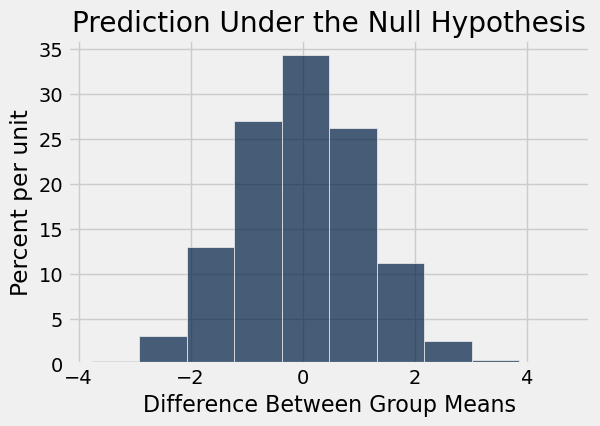

In [20]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis')
plots.show()

Notice how the distribution is centered roughly around 0. This makes sense, because under the null hypothesis the two groups should have roughly the same average. Therefore the difference between the group averages should be around 0.

The observed difference in the original sample is about $-9.27$ ounces, which doesn't even appear on the horizontal scale of the histogram. The observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent. 

The conclusion of the test is that the data favor the alternative over the null. It supports the hypothesis that the average birth weight of babies born to mothers who smoke is less than the average birth weight of babies born to non-smokers.

If you want to compute an empirical p-value, remember that low values of the statistic favor the alternative hypothesis. 

In [21]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

The empirical p-value is 0, meaning that none of the 5,000 permuted samples resulted in a difference of -9.27 or lower. This is only an approximation. The exact chance of getting a difference in that range is not 0. But it is vanishingly small, according to our simulation, and therefore we can reject the null hypothesis.

## Another Permutation Test
We can use the same method to compare other attributes of the smokers and the non-smokers, such as their ages. Histograms of the ages of the two groups show that in the sample, the mothers who smoked tended to be younger. 

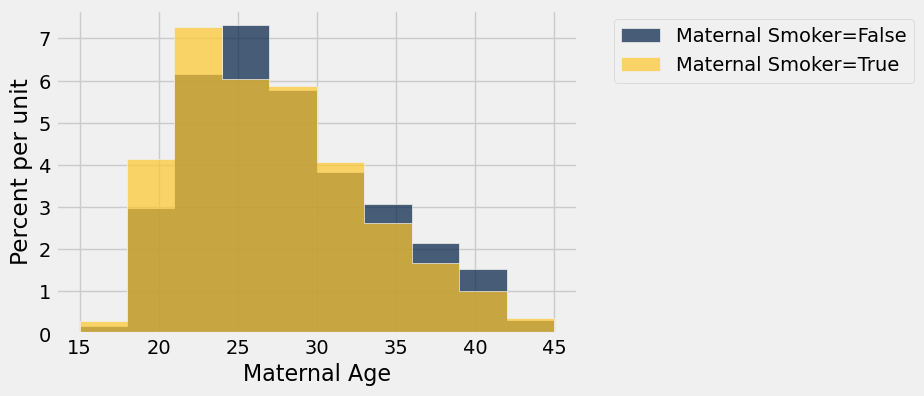

In [22]:
smoking_and_age = births.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')
plots.show()

검정통계량 : 이 두 차이를 어떻게 설명 할거냐

The observed difference between the average ages is about $-0.8$ years.

Let's rewrite the code that compared the birth weights so that it now compares the ages of the smokers and non-smokers.

In [23]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select('Maternal Age', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [24]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

Remember that the difference is calculated as the mean age of the smokers minus the mean age of the non-smokers. The negative sign shows that the smokers are younger on average.

Is this difference due to chance, or does it reflect an underlying difference in the population?

As before, we can use a permutation test to answer this question. If the underlying distributions of ages in the two groups are the same, then the empirical distribution of the difference based on permuted samples will predict how the statistic should vary due to chance.

We will follow the same process as in any simulation. We will start by writing a function that returns one simulated value of the difference between means, and then write a `for` loop to simulate numerous such values and collect them in an array.

In [25]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean ages
    of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of ages and shuffled labels
    shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [26]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

The observed difference is in the tail of the empirical distribution of the differences simulated under the null hypothesis. 

In [27]:
Table().with_column(
    'Difference Between Group Means', age_differences).hist(
    right_end = observed_age_difference)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

Observed Difference: -0.8076725017901509


Once again, the empirical distribution of the simulated differences is centered roughly around 0, because the simulation is under the null hypothesis that there is no difference between the distributions of the two groups.

The empirical p-value of the test is the proportion of simulated differences that were equal to or less than the observed difference. This is because low values of the difference favor the alternative hypothesis that the smokers were younger on average.

In [28]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0084

The empirical p-value is around 1% and therefore the result is statistically significant. The test supports the hypothesis that the smokers were younger on average.